In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import joblib
import time
np.random.seed(2)

In [2]:
def load_all(fname):
    return joblib.load(fname)

def load_cls(fname):
    return np.array(pickle.load(open(fname,"rb")))

In [3]:
trainSamples = 75000
path = "/scratch/pbanerj6/sml-dataset/"
n_iter = 1000 
n_trainSamples = [100,500,1000,10000,20000,50000,75000]

In [4]:
X_train_all = load_all(path+"X_train_all.jblib")[:trainSamples]
X_val_all = load_all(path+"X_val_all.jblib")

y_train = load_cls(path+"y_train.p")[:trainSamples]
y_val = load_cls(path+"y_val.p")

In [5]:
print (X_train_all[0].shape)
print (X_train_all.shape)
print (X_train_all[0])
print (max(X_train_all[0]))
print (X_val_all[0].shape)
print (X_val_all.shape)
print (X_val_all[0])
print (max(X_val_all[0]))

(25344,)
(75000, 25344)
[ 1.423734 -0.114695 -0.154449 ...  0.        0.        0.      ]
29.085083000000004
(25344,)
(15000, 25344)
[ 0.372583 -1.620609  0.19897  ...  0.        0.        0.      ]
29.021265


In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train_all)
X_train_all = scaler.transform(X_train_all)
print(X_train_all)

[[0.7659044  0.70855075 0.39920816 ... 0.48818811 0.53466314 0.45362774]
 [0.77855699 0.59108994 0.6831954  ... 0.48818811 0.53466314 0.45362774]
 [0.66231604 0.68651978 0.21004461 ... 0.48818811 0.53466314 0.45362774]
 ...
 [0.68410026 0.50661388 0.22069108 ... 0.48818811 0.53466314 0.45362774]
 [0.68410026 0.50661388 0.22069108 ... 0.48818811 0.53466314 0.45362774]
 [0.68410026 0.50661388 0.22069108 ... 0.48818811 0.53466314 0.45362774]]


In [7]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.get_params().keys()

dict_keys(['priors', 'var_smoothing'])

In [8]:
model = gnb.fit(X_train_all, y_train)

In [9]:
pickle.dump(model,open("GNB_ALL_"+str(trainSamples)+"_"+str(n_iter)+".pkl",'wb'))

In [10]:
X_test_all = load_all(path+"X_test_all.jblib")
y_test = load_cls(path+"y_test.p")

In [11]:
from scipy.stats import rankdata

def mrrs(out, labels):
#     print(out,labels)
    outputs = np.argmax(out,axis=1)
    mrr = 0.0 
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        mrr+=1/rank
    return mrr/len(labels)

def precision_at(out,labels,prank=1):
    count = 0
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        if rank <= prank:
            count+=1
    return count/len(labels)

def mrrwrapper(qid2c,qid2indexmap,preds_prob):
    labels = []
    out = []
    for qid in qid2c.keys():
        scores = []
        for ix in qid2indexmap[qid]:
            if len(scores) < 6:
                scores.append(preds_prob[ix][1])
        if len(scores) < 6:
            continue
        out.append(scores)
        labels.append(int(qid2c[qid]))
    return mrrs(np.array(out),labels),precision_at(np.array(out),labels,1),precision_at(np.array(out),labels,3)

def load_ranking(fname):
    return pickle.load(open(path+"ranking_"+fname+".p","rb"))

In [12]:
from sklearn.metrics import accuracy_score

In [13]:
valAccuracy = []
testAccuracy = []
mrrScore = []
precisionAt1 = []
precisionAt3 = []

# For each of training sample sizes
for eachTrain in n_trainSamples:
    
    # Model with best values from grid search
    bestModel = GaussianNB()

    print("SampleSize:",eachTrain)
    
    stime=time.time()
    bestModel.fit(X_train_all[:eachTrain],y_train[:eachTrain])   
    print("Train Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    preds_val = bestModel.predict(X_val_all)
    accuracy = round(accuracy_score(y_val, preds_val),4)
    valAccuracy.append(accuracy)
    print("Validation Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Validation Time:%.2f sec"%(time.time()-stime))

    stime=time.time()
    preds_test = bestModel.predict(X_test_all)
    accuracy = round(accuracy_score(y_test, preds_test),4)
    testAccuracy.append(accuracy)
    print("Test Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Test Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    preds_test_probs = bestModel.predict_proba(X_test_all)
    qid2c,qid2indexmap = load_ranking("test")
    print (mrrwrapper(qid2c,qid2indexmap,preds_test_probs))
    mrr, pAt1, pAt3 = mrrwrapper(qid2c,qid2indexmap,preds_test_probs)
    mrrScore.append(mrr)
    print("MRR:",mrr)
    print("MRR Time:%.2f sec"%(time.time()-stime))
    print("------------------------------------")
    precisionAt1.append(pAt1)
    precisionAt3.append(pAt3)
    
    #input()
print (valAccuracy)
print (testAccuracy)
print (mrrScore)
print (precisionAt1)
print (precisionAt3)

SampleSize: 100
Train Time:0.06 sec
Validation Accuracy: 50.00%
Validation Time:4.90 sec
Test Accuracy: 50.00%
Test Time:5.16 sec
(0.2857142857142808, 0.0, 0.0)
MRR: 0.2857142857142808
MRR Time:5.38 sec
------------------------------------
SampleSize: 500
Train Time:0.21 sec
Validation Accuracy: 52.99%
Validation Time:4.74 sec
Test Accuracy: 52.33%
Test Time:4.81 sec
(0.3540399711399695, 0.066, 0.23533333333333334)
MRR: 0.3540399711399695
MRR Time:5.27 sec
------------------------------------
SampleSize: 1000
Train Time:0.42 sec
Validation Accuracy: 53.43%
Validation Time:4.75 sec
Test Accuracy: 53.44%
Test Time:4.77 sec
(0.3628839826839815, 0.08066666666666666, 0.21333333333333335)
MRR: 0.3628839826839815
MRR Time:5.29 sec
------------------------------------
SampleSize: 10000
Train Time:4.38 sec
Validation Accuracy: 51.37%
Validation Time:4.87 sec
Test Accuracy: 51.03%
Test Time:5.19 sec
(0.2944396344396296, 0.0, 0.17533333333333334)
MRR: 0.2944396344396296
MRR Time:5.77 sec
--------

In [14]:
def accuracyVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,testAccuracy,label='TestAccuracy vs TrainData',marker='o')
    ax.plot(n_trainSamples,valAccuracy,label='ValAccuracy vs TrainData',marker='.')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("GNB_All_Accuracy.png")
    #plt.show()

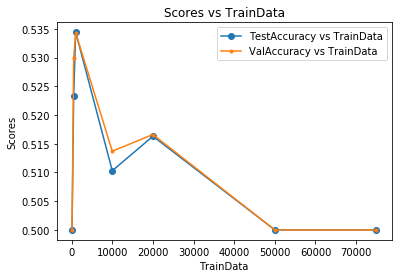

In [15]:
accuracyVisualization()

In [16]:
def mrrVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,mrrScore,label='MRR vs TrainData',marker='x')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("GNB_All_Mrr.png")
    plt.show()

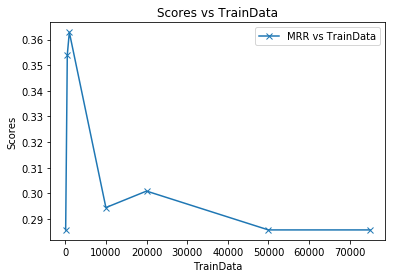

In [17]:
mrrVisualization()

In [18]:
def precisionVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,precisionAt1,label='Precision@1 vs TrainData',marker='x')
    ax.plot(n_trainSamples,precisionAt3,label='Precision@3 vs TrainData',marker='o')
    plt.title("Precisions vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Precisions")
    fig.savefig("GNB_All_Precision.png")
    plt.show()

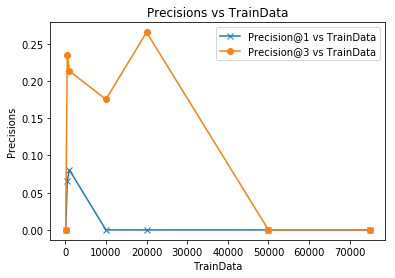

In [19]:
precisionVisualization()